In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import seaborn as sb
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/data/keeling/a/alfonso8/projects/simles_proj/data/US_MaizeYield_Predictors_1950-2013.csv')
df['fips'] = df['fips'].astype(str).astype(int)
df.index = df['fips']

In [3]:
# drop counties with less than 30 obs
good_counties = df.groupby(df.index).count()['yield'] >= 30 
df = df.loc[good_counties]


In [4]:
df = df.set_index(['fips', 'year'], drop=False)

# Choose subset of predictors
predictors = ['year',
              'GDD_4', 'GDD_5', 'GDD_6', 'GDD_7', 'GDD_8', 'GDD_9', 
              'EDD_4', 'EDD_5', 'EDD_6', 'EDD_7', 'EDD_8', 'EDD_9',
              'prcp_4', 'prcp_5', 'prcp_6', 'prcp_7', 'prcp_8', 'prcp_9',
              'prcp2_4', 'prcp2_5', 'prcp2_6', 'prcp2_7', 'prcp2_8', 'prcp2_9',
              'maize_irr_frac']

<AxesSubplot:>

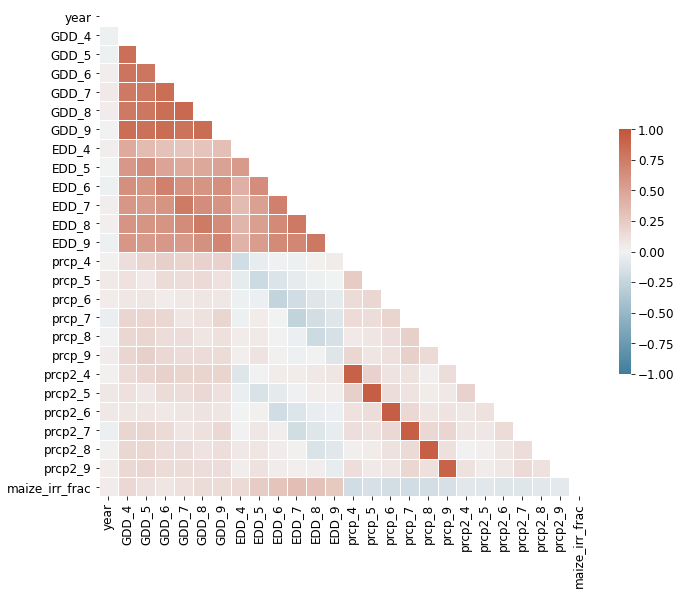

In [5]:
## Looking correlations between predictors

corr  = df[predictors].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.rcParams.update({'font.size': 12})
axis_font = {'size':'12'}
f, ax = plt.subplots(figsize=(11, 9))

cmap = sb.diverging_palette(230, 20, as_cmap=True)

sb.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

In [6]:
## Selecting Champing as subset for further analysis
test = df.query('fips == 17019')

In [7]:
x = test[predictors]
y = test['yield']

# Spliting data into train and test data set for future score evaluations (35% of the data for testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)


In [8]:
## Applying a Lasso regresion model
lasso_model = Lasso()
lasso_model.fit(x_train, y_train)
predicted = lasso_model.predict(x_test)
score = lasso_model.score(x_test, y_test)

## Calculating residuals
residuals = y_test - predicted

## Estimating absolute values of the residual and normalizing
abs_res = np.abs(residuals) / y_test

In [9]:
## Training Model Score
lasso_model.score(x_train, y_train)

0.9324987361475316

In [10]:
## Test model score
score

0.833897285679227

In [11]:
### Probably the model is overfited (high train score than test score)

In [12]:
## looking the absolute values of the coeficients (predictors)

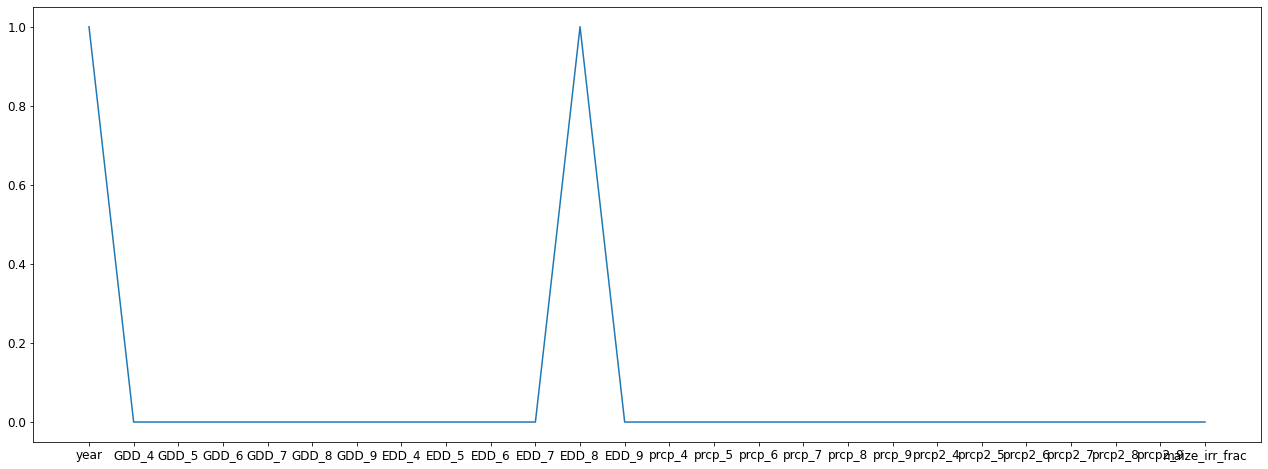

In [13]:
coefs = np.floor(np.abs(lasso_model.coef_))
fig, ax = plt.subplots(figsize=(22, 8))
plt.plot(coefs)
plt.xticks(np.arange(len(predictors)), predictors);

In [14]:
## Creating a pairplot where we can see scatter plots and distributions among the predictors and the expected variable
# z = pd.concat([x, y], axis=1)

In [15]:
# sb.pairplot(z)

In [16]:
## looking for the an automatic selection of each predictor (importance of each predictor/feature)

In [17]:
from sklearn.feature_selection import SelectKBest ## univariate analysis for feature selection
from sklearn.feature_selection import mutual_info_regression # metric for feature selection 

In [18]:
selector = SelectKBest(mutual_info_regression, k=len(predictors)) # select the k best features

In [19]:
selector.fit(x, y) 

SelectKBest(k=26,
            score_func=<function mutual_info_regression at 0x2b07f7040e50>)

In [20]:
feat_scores = selector.scores_

In [21]:
feat_scores

array([9.69901125e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.82425750e-04, 0.00000000e+00, 0.00000000e+00,
       3.58785605e-02, 1.16373583e-01, 0.00000000e+00, 1.77626026e-02,
       2.05020056e-02, 1.88029336e-03, 1.29539579e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.50892301e-03, 0.00000000e+00, 1.17391908e-02, 0.00000000e+00,
       1.66662245e-02, 0.00000000e+00])

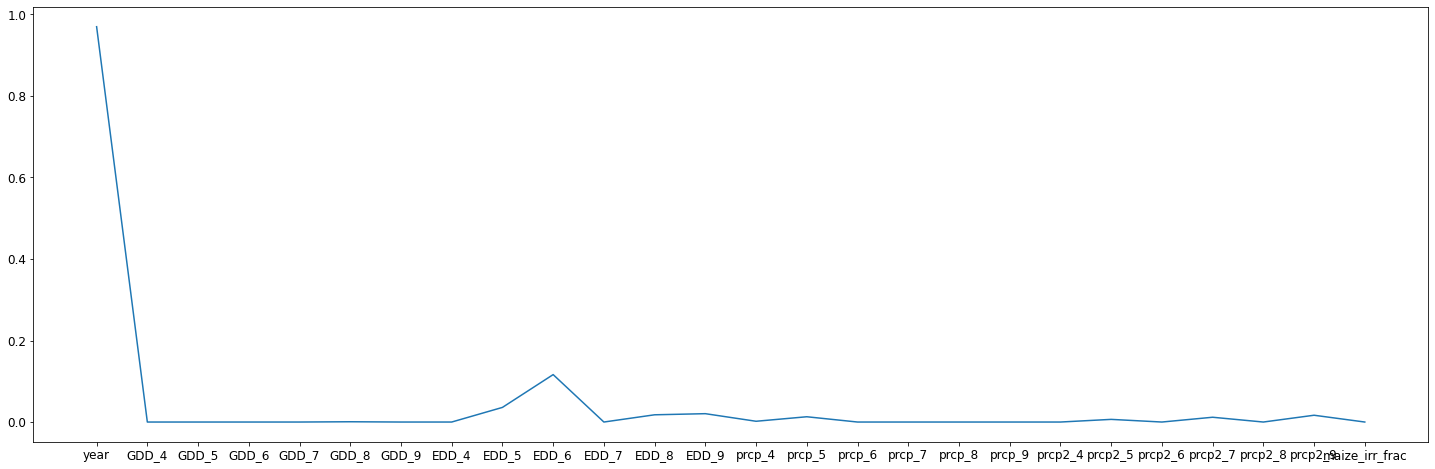

In [22]:
fig, ax = plt.subplots(figsize=(25, 8))
plt.plot(feat_scores)
plt.xticks(np.arange(len(predictors)), predictors);

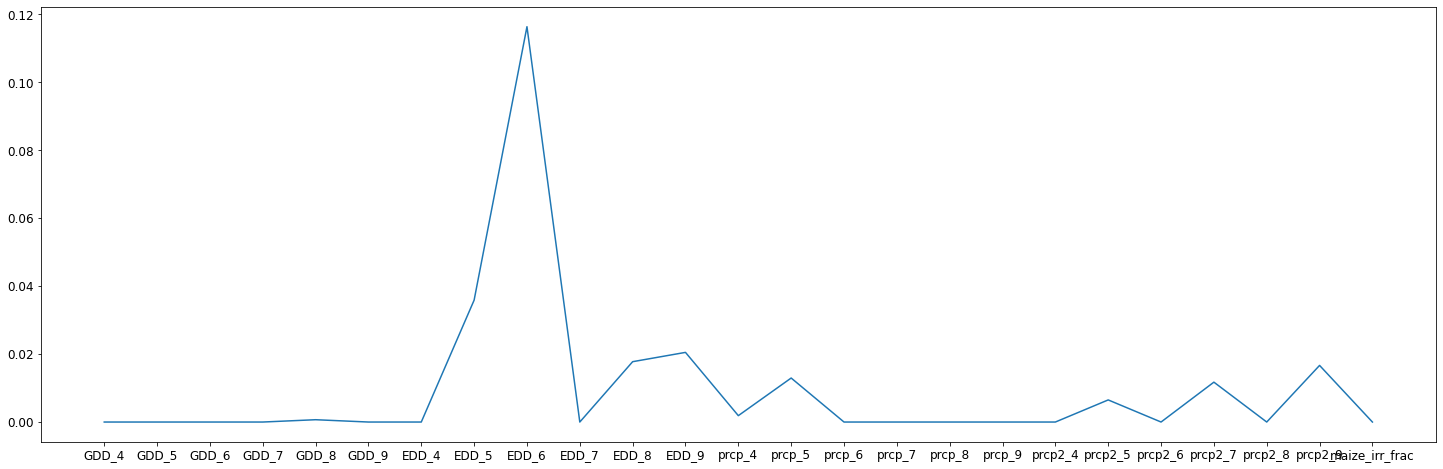

In [23]:
## getting rid of year to see more detail over the other predictors

fig, ax = plt.subplots(figsize=(25, 8))
plt.plot(feat_scores[1:])
plt.xticks(np.arange(len(predictors[1:])), predictors[1:]);

In [24]:
## selecting the best predictors
feat_scores

array([9.69901125e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.82425750e-04, 0.00000000e+00, 0.00000000e+00,
       3.58785605e-02, 1.16373583e-01, 0.00000000e+00, 1.77626026e-02,
       2.05020056e-02, 1.88029336e-03, 1.29539579e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.50892301e-03, 0.00000000e+00, 1.17391908e-02, 0.00000000e+00,
       1.66662245e-02, 0.00000000e+00])

In [25]:
### 4 best predictors/features
idx1 = feat_scores.argsort()[::-1][:4]
predictors1 = [predictors[i] for i in idx1]

### 6 best predictors/features

idx2 = feat_scores.argsort()[::-1][:6]
predictors2 = [predictors[i] for i in idx2]

### 8 best predictors/features

idx3 = feat_scores.argsort()[::-1][:8]
predictors3 = [predictors[i] for i in idx3]

### 12 best predictors/features

idx4 = feat_scores.argsort()[::-1][:12]
predictors4 = [predictors[i] for i in idx4]

In [26]:
## repeting training and testing to see if we can get better scores

In [27]:
## selecting the columns

x1 = test[predictors1]
x2 = test[predictors2]
x3 = test[predictors3]
x4 = test[predictors4]

In [28]:
## spliting into training and testing
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y, test_size=0.35)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y, test_size=0.35)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y, test_size=0.35)

In [29]:
lasso_model1 = Lasso()
lasso_model1.fit(x1_train, y1_train)
train_score1 = lasso_model1.score(x1_train, y1_train)
predicted1 = lasso_model1.predict(x1_test)
test_score1 = lasso_model1.score(x1_test, y1_test)

print(train_score1, test_score1)

0.7513899494732367 0.6419713952906538


In [30]:
lasso_model2 = Lasso()
lasso_model2.fit(x2_train, y2_train)
train_score2 = lasso_model2.score(x2_train, y2_train)
predicted2 = lasso_model2.predict(x2_test)
test_score2 = lasso_model2.score(x2_test, y2_test)
print(train_score2, test_score2)

0.8944712896117926 0.5562643891544139


In [31]:
lasso_model3 = Lasso()
lasso_model3.fit(x3_train, y3_train)
train_score3 = lasso_model3.score(x3_train, y3_train)
predicted3 = lasso_model3.predict(x3_test)
test_score3 = lasso_model3.score(x3_test, y3_test)
print(train_score3, test_score3)

0.9100997167495315 0.6835062656984399


In [61]:
## looking the error rate
score_train = []
score_test = []
for i in range(len(feat_scores)):
    i+= 1
    idxn = feat_scores.argsort()[::-1][:i]
    predictors_n = [predictors[i] for i in idxn]
    xn = test[predictors_n]
    xn_train, xn_test, yn_train, yn_test = train_test_split(xn, y, test_size=0.35)
    
    lasso_modeln = Lasso()
    lasso_modeln.fit(xn_train, yn_train)
    train_scoren = lasso_modeln.score(xn_train, yn_train)
    predictedn = lasso_modeln.predict(xn_test)
    test_scoren = lasso_modeln.score(xn_test, yn_test)
    score_train.append(train_scoren)
    score_test.append(test_scoren)

In [62]:
score_train = np.array(score_train)


In [63]:
score_test = np.array(score_test)

In [64]:
error  = 1 - score_test

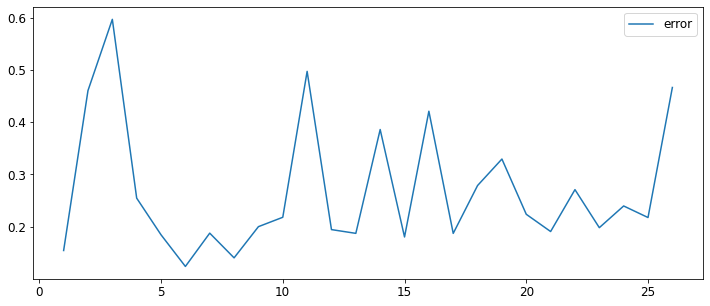

In [65]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(np.arange(1, len(predictors) + 1), error, label='error')
plt.legend()

Text(0, 0.5, 'error')

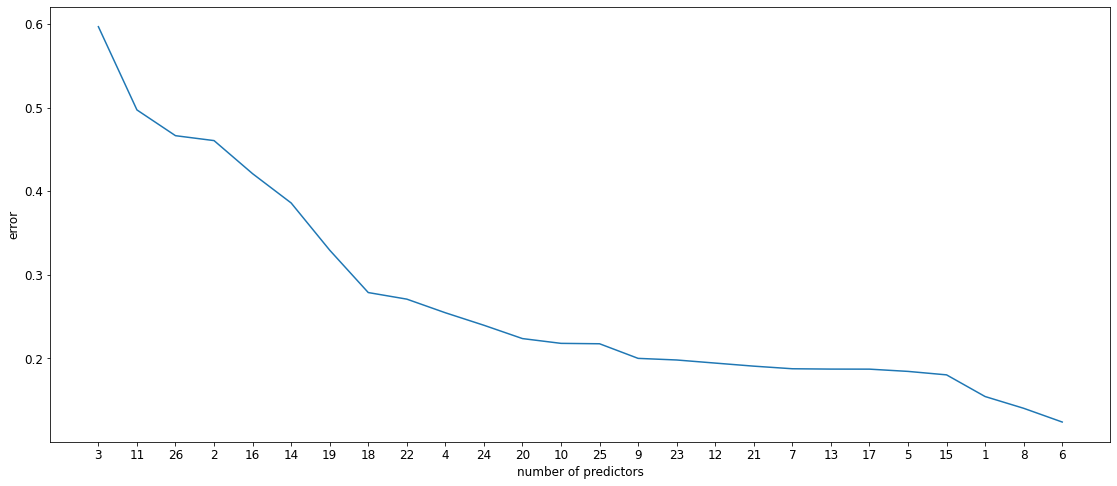

In [66]:
fig, ax = plt.subplots(figsize=(19, 8))
idxsorted = np.argsort(error)
plt.plot(error[idxsorted[::-1]])
a = np.arange(1, len(predictors) + 1, 1)
plt.xticks(a -1, a[idxsorted[::-1]]);
plt.xlabel('number of predictors')
plt.ylabel('error')

In [67]:
## so, over best model is using 10 predictors. The training score is similar to the test score

In [68]:
## however, each time that the code is executed the test, training data set changes which might not create a solid feature 
## selection

In [69]:
## Now, I think we can use a cross validation method

In [70]:
from sklearn.model_selection import cross_val_score

In [71]:
## this might be a more robust score 

In [72]:
scores1 = cross_val_score(Lasso(), x1, y, cv=3, scoring='r2')
print(scores1, scores1.mean())

[ 0.08850752 -0.21522352 -0.13099672] -0.08590424096788656


In [73]:
scores1 = cross_val_score(Lasso(), x2, y, cv=3, scoring='r2')
print(scores1, scores1.mean() / len(scores1))

[0.25092385 0.29229297 0.34588257] 0.09878881985010118


In [74]:
scores1 = cross_val_score(Lasso(), x3, y, cv=3, scoring='r2')
print(scores1, scores1.mean())

[0.38401109 0.41765568 0.27148621] 0.3577176600937975


In [75]:
## under this 

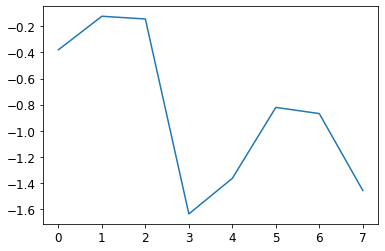

In [76]:
scores_cv = []
for i in np.arange(2, 10):
    scores_cvn = cross_val_score(Lasso(), x, y, cv=i, scoring='r2')
    scores_cv.append(np.mean(scores_cvn))

plt.plot(scores_cv)

Text(0, 0.5, 'score')

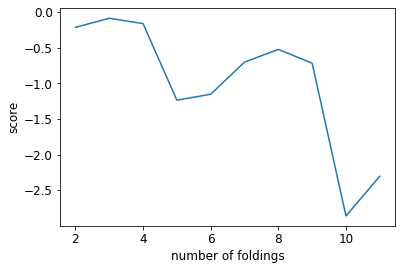

In [77]:
scores_cv = []
for i in np.arange(2, 12):
    scores_cvn = cross_val_score(Lasso(), x1, y, cv=i, scoring='r2')
    scores_cv.append(np.mean(scores_cvn))

plt.plot(np.arange(2, 12), scores_cv)
plt.xlabel('number of foldings')
plt.ylabel('score')

Text(0, 0.5, 'score')

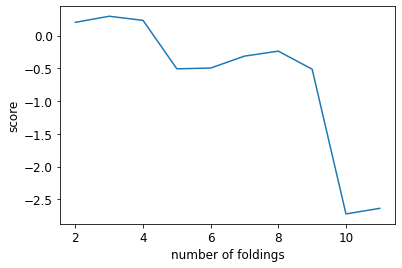

In [78]:
scores_cv = []
for i in np.arange(2, 12):
    scores_cvn = cross_val_score(Lasso(), x2, y, cv=i, scoring='r2')
    scores_cv.append(np.mean(scores_cvn))

plt.plot(np.arange(2, 12), scores_cv)
plt.xlabel('number of foldings')
plt.ylabel('score')

Text(0, 0.5, 'score')

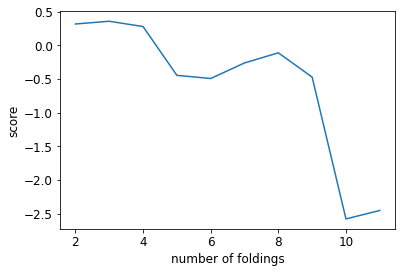

In [79]:
scores_cv = []
for i in np.arange(2, 12):
    scores_cvn = cross_val_score(Lasso(), x3, y, cv=i, scoring='r2')
    scores_cv.append(np.mean(scores_cvn))

plt.plot(np.arange(2, 12), scores_cv)
plt.xlabel('number of foldings')
plt.ylabel('score')

Text(0, 0.5, 'score')

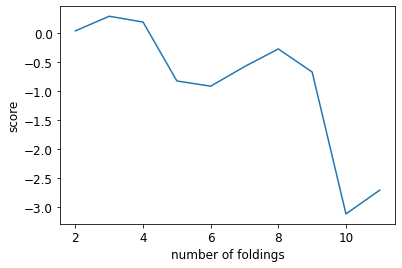

In [80]:
scores_cv = []
for i in np.arange(2, 12):
    scores_cvn = cross_val_score(Lasso(), x4, y, cv=i, scoring='r2')
    scores_cv.append(np.mean(scores_cvn))

plt.plot(np.arange(2, 12), scores_cv)
plt.xlabel('number of foldings')
plt.ylabel('score')

In [ ]:
## as we can see after 8 folding the model present very low mean score values